![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/nlu/blob/master/examples/webinars_conferences_etc/multi_lingual_webinar/4_Unsupervise_Chinese_Keyword_Extraction_NER_and_Translation_from_Chinese_News.ipynb)

![Flags](http://ckl-it.de/wp-content/uploads/2021/02/flags.jpeg)

In [ ]:
import os
! apt-get update -qq > /dev/null   
# Install java
! apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]
! pip install nlu  pyspark==2.4.4  > /dev/null    
import nlu  
import pandas as pd 
! wget http://ckl-it.de/wp-content/uploads/2021/02/chinese_news.csv

--2021-02-17 12:04:57--  http://ckl-it.de/wp-content/uploads/2021/02/chinese_news.csv
Resolving ckl-it.de (ckl-it.de)... 217.160.0.108, 2001:8d8:100f:f000::209
Connecting to ckl-it.de (ckl-it.de)|217.160.0.108|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21914526 (21M) [text/csv]
Saving to: ‘chinese_news.csv’

chinese_news.csv    100%[===================>]  20.90M  6.54MB/s    in 3.5s    

2021-02-17 12:05:01 (5.99 MB/s) - ‘chinese_news.csv’ saved [21914526/21914526]



# Analyzing chinese News Articles With NLU
## This notebook showcases how to extract Chinese Keywords  Unsupervied with YAKE and Named Entities and translate them to English
### In addition, we will leverage the Chinese WordSegmenter and Lemmatizer to preprocess our data further and get a better view fof our data distribution


# [Chinese official daily news](https://www.kaggle.com/noxmoon/chinese-official-daily-news-since-2016)
![Chinese News](https://upload.wikimedia.org/wikipedia/zh/6/69/XINWEN_LIANBO.png)
### Xinwen Lianbo is a daily news programme produced by China Central Television. It is shown simultaneously by all local TV stations in mainland China, making it one of the world's most-watched programmes. It has been broadcast since 1 January 1978.
wikipedia



In [ ]:
df = pd.read_csv('./chinese_news.csv')
df

,date,tag,headline,content
0,2016-01-01,详细全文,陆军领导机构火箭军战略支援部队成立大会在京举行 习近平向中国人民解放军陆军火箭军战略支援部队...,中国人民解放军陆军领导机构、中国人民解放军火箭军、中国人民解放军战略支援部队成立大会2015...
1,2016-01-01,详细全文,中央军委印发《关于深化国防和军队改革的意见》,经中央军委主席习近平批准，中央军委近日印发了《关于深化国防和军队改革的意见》。\n《意见》强...
2,2016-01-01,详细全文,《习近平关于严明党的纪律和规矩论述摘编》出版发行,由中共中央纪律检查委员会、中共中央文献研究室编辑的《习近平关于严明党的纪律和规矩论述摘编》一...
3,2016-01-01,详细全文,以实际行动向党中央看齐 向高标准努力,广大党员干部正在积极学习习近平总书记在中央政治局专题民主生活会上的重要讲话。大家纷纷表示要把...
4,2016-01-01,详细全文,【年终特稿】关键之年 改革挺进深水区,刚刚过去的2015年，是全面深化改革的关键之年。改革集中发力在制约经济社会发展的深层次矛盾，...
...,...,...,...,...
20733,2018-10-09,国际,部分反政府武装从伊德利卜撤重武器,土耳其官方媒体日前报道说，根据俄土达成的在叙利亚伊德利卜“建立非军事区”的协议，叙利亚反政府...
20734,2018-10-09,国际,IMF下调今明两年世界经济增长预期,国际货币基金组织北京时间今天发布报告宣布，将今明两年世界经济增速预期下调至3.7%，比此前7...
20735,2018-10-09,国际,乌克兰一军火库爆炸 上万人疏散,9日，乌克兰切尔尼戈夫地区一座军火库发生爆炸。事发地位于乌克兰首都基辅东部约176公里处，事...
20736,2018-10-09,国际,联合国：全球控温“1.5度”更有益处,联合国政府间气候变化专门委员会8日发布“全球升温1.5℃特别报告”。报告显示，如果气候变暖以...


# Depending how we pre-process our text, we will get different keywords extracted with YAKE. In This tutorial we will see the effect of **Lemmatization** and **Word Segmentation** and see how the distribution of Keywords changes 
- Lemmatization
- Word Segmentation

# Apply YAKE - Keyword Extractor to the raw text
First we do no pre-processing at all and just calculate keywords from the raw titles with YAKE

In [ ]:
yake_df = nlu.load('yake').predict(df.headline)
yake_df

,headline,keywords_classes,document,keywords_confidences,text
origin_index,,,,,
0,陆军领导机构火箭军战略支援部队成立大会在京举行 习近平向中国人民解放军陆军火箭军战略支援部队...,"[陆军领导机构火箭军战略支援部队成立大会在京举行, 习近平向中国人民解放军陆军火箭军战略支援...",陆军领导机构火箭军战略支援部队成立大会在京举行 习近平向中国人民解放军陆军火箭军战略支援部队...,"[0.5527606010437012, 0.354549765586853, 0.1218...",陆军领导机构火箭军战略支援部队成立大会在京举行 习近平向中国人民解放军陆军火箭军战略支援部队...
1,中央军委印发《关于深化国防和军队改革的意见》,[],中央军委印发《关于深化国防和军队改革的意见》,[],中央军委印发《关于深化国防和军队改革的意见》
2,《习近平关于严明党的纪律和规矩论述摘编》出版发行,[],《习近平关于严明党的纪律和规矩论述摘编》出版发行,[],《习近平关于严明党的纪律和规矩论述摘编》出版发行
3,以实际行动向党中央看齐 向高标准努力,"[以实际行动向党中央看齐, 向高标准努力, 以实际行动向党中央看齐 向高标准努力, 以实际行...",以实际行动向党中央看齐 向高标准努力,"[0.5527606010437012, 0.354549765586853, 0.1218...",以实际行动向党中央看齐 向高标准努力
4,【年终特稿】关键之年 改革挺进深水区,[改革挺进深水区],【年终特稿】关键之年 改革挺进深水区,[0.354549765586853],【年终特稿】关键之年 改革挺进深水区
...,...,...,...,...,...
20733,部分反政府武装从伊德利卜撤重武器,"[部分反政府武装从伊德利卜撤重武器, 部分反政府武装从伊德利卜撤重武器, 部分反政府武装从伊...",部分反政府武装从伊德利卜撤重武器,"[0.11818325519561768, 0.11818325519561768, 0.1...",部分反政府武装从伊德利卜撤重武器
20734,IMF下调今明两年世界经济增长预期,"[imf下调今明两年世界经济增长预期, imf下调今明两年世界经济增长预期, imf下调今明...",IMF下调今明两年世界经济增长预期,"[0.11818325519561768, 0.11818325519561768, 0.1...",IMF下调今明两年世界经济增长预期
20735,乌克兰一军火库爆炸 上万人疏散,"[乌克兰一军火库爆炸, 上万人疏散, 乌克兰一军火库爆炸 上万人疏散, 乌克兰一军火库爆炸 ...",乌克兰一军火库爆炸 上万人疏散,"[0.5527606010437012, 0.354549765586853, 0.1218...",乌克兰一军火库爆炸 上万人疏散


##  The predicted Chinese Keywords dont show up on Pandas Label and you probably do not speek Chinese!
### This is why we will translate each extracted Keyword into english and then take a look at the distribution again

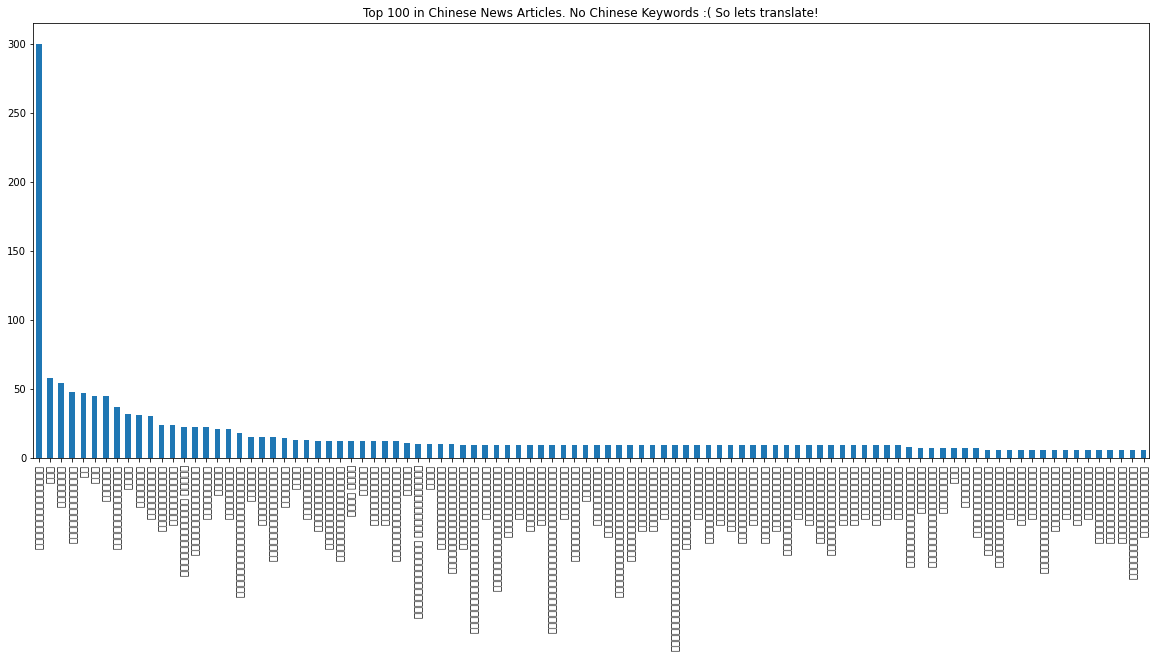

In [ ]:
yake_df.explode('keywords_classes').keywords_classes.value_counts()[0:100].plot.bar(title='Top 100 in Chinese News Articles. No Chinese Keywords :( So lets translate!', figsize=(20,8))

### We get the top 100 keywords and store the counts toegether with the keywords in a new DF

In [ ]:
top_100_zh = yake_df.explode('keywords_classes').keywords_classes.value_counts()[0:100]
top_100_zh = pd.DataFrame(top_100_zh)
# Create new DF from the counts
top_100_zh['zh'] = top_100_zh.index
top_100_zh.reset_index(inplace=True)
top_100_zh


,index,keywords_classes,zh
0,李克强主持召开国务院常务会议,300,李克强主持召开国务院常务会议
1,新气象,58,新气象
2,十九大代表风采,54,十九大代表风采
3,全国政协召开双周协商座谈会,48,全国政协召开双周协商座谈会
4,中办,47,中办
...,...,...,...
95,美联储维持联邦基金利率不变,6,美联储维持联邦基金利率不变
96,习近平应约同韩国总统通电话,6,习近平应约同韩国总统通电话
97,刘云山会见古巴共产党代表团,6,刘云山会见古巴共产党代表团
98,张德江看望参加人大会议报道的新闻工作者,6,张德江看望参加人大会议报道的新闻工作者


### Now we can just translate each predicted keyword with `zh.translate_to.en` in 1 line of code and see what is actually going on in the dataset

In [ ]:
top_100_en = nlu.load('zh.translate_to.en').predict(top_100_zh.zh)
top_100_en

translate_zh_en download started this may take some time.
Approx size to download 396.8 MB
[OK!]


,zh,sentence,translation,text
origin_index,,,,
0,李克强主持召开国务院常务会议,李克强主持召开国务院常务会议,Li Keqiang is presiding over the State Departm...,李克强主持召开国务院常务会议
1,新气象,新气象,New Weather,新气象
2,十九大代表风采,十九大代表风采,Nineteen is a great sign.,十九大代表风采
3,全国政协召开双周协商座谈会,全国政协召开双周协商座谈会,The National Political Consultative Council ho...,全国政协召开双周协商座谈会
4,中办,中办,Organisation,中办
...,...,...,...,...
95,美联储维持联邦基金利率不变,美联储维持联邦基金利率不变,The Fed maintains the federal fund rate unchan...,美联储维持联邦基金利率不变
96,习近平应约同韩国总统通电话,习近平应约同韩国总统通电话,Xi has been on the phone with the President of...,习近平应约同韩国总统通电话
97,刘云山会见古巴共产党代表团,刘云山会见古巴共产党代表团,Liu Yunshan met with the delegation of the Com...,刘云山会见古巴共产党代表团


#### Write the translations into the df with the Keyword counts so we can plot them together in the next step

In [ ]:
# Write translation back to the keyword df with the counts
top_100_zh['en']= top_100_en.translation
top_100_zh

,index,keywords_classes,zh,en
0,李克强主持召开国务院常务会议,300,李克强主持召开国务院常务会议,Li Keqiang is presiding over the State Departm...
1,新气象,58,新气象,New Weather
2,十九大代表风采,54,十九大代表风采,Nineteen is a great sign.
3,全国政协召开双周协商座谈会,48,全国政协召开双周协商座谈会,The National Political Consultative Council ho...
4,中办,47,中办,Organisation
...,...,...,...,...
95,美联储维持联邦基金利率不变,6,美联储维持联邦基金利率不变,The Fed maintains the federal fund rate unchan...
96,习近平应约同韩国总统通电话,6,习近平应约同韩国总统通电话,Xi has been on the phone with the President of...
97,刘云山会见古巴共产党代表团,6,刘云山会见古巴共产党代表团,Liu Yunshan met with the delegation of the Com...
98,张德江看望参加人大会议报道的新闻工作者,6,张德江看望参加人大会议报道的新闻工作者,The journalist Jang Deok-kyung visited the con...


## Now we can simply look at every keyword as a bar chart with the actual translation of it and understand what keywordsa ppeared in chinese news!

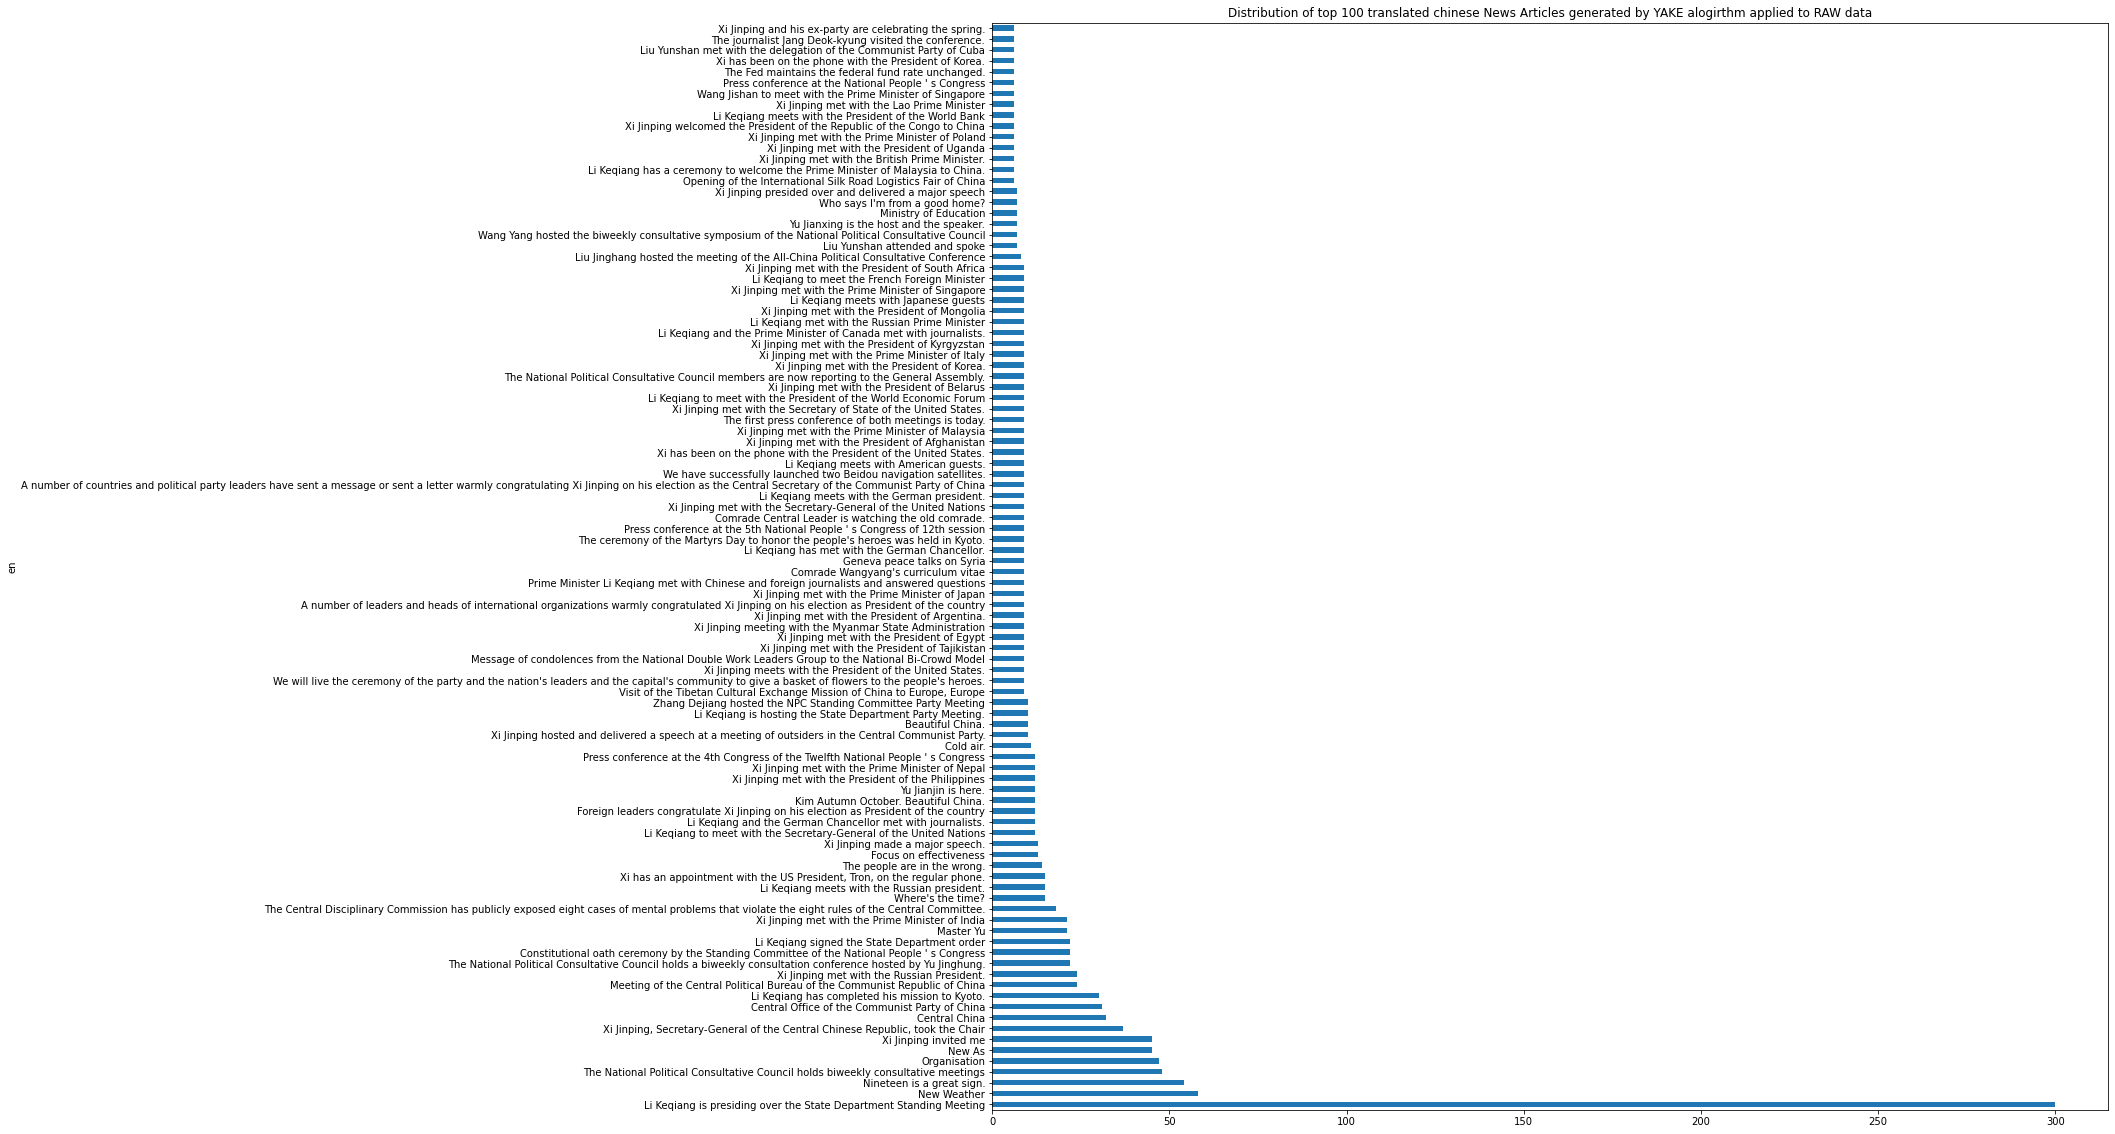

In [ ]:
top_100_zh.index = top_100_zh.en
top_100_zh.keywords_classes.plot.barh(figsize=(20,20), title='Distribution of top 100 translated chinese News Articles generated by YAKE alogirthm applied to RAW data')

# Apply Yake to Segmented/Tokenized data
We gave the YAKE algorithm full heatlines which where not segmented. To better understand the Chinese text ,we can segment it into token and analyze their occurcence instead
## YAKE + Word Segmentation

In [ ]:
# Segment words into tokenz with the word segmenter
# This will output 1 row per token
seg_df = nlu.load('zh.segment_words').predict(df.headline)
seg_df 

wordseg_weibo download started this may take some time.
Approximate size to download 1.2 MB
[OK!]


,text,token,headline
origin_index,,,
0,陆军领导机构火箭军战略支援部队成立大会在京举行 习近平向中国人民解放军陆军火箭军战略支援部队...,陆领,陆军领导机构火箭军战略支援部队成立大会在京举行 习近平向中国人民解放军陆军火箭军战略支援部队...
0,陆军领导机构火箭军战略支援部队成立大会在京举行 习近平向中国人民解放军陆军火箭军战略支援部队...,军,陆军领导机构火箭军战略支援部队成立大会在京举行 习近平向中国人民解放军陆军火箭军战略支援部队...
0,陆军领导机构火箭军战略支援部队成立大会在京举行 习近平向中国人民解放军陆军火箭军战略支援部队...,导机,陆军领导机构火箭军战略支援部队成立大会在京举行 习近平向中国人民解放军陆军火箭军战略支援部队...
0,陆军领导机构火箭军战略支援部队成立大会在京举行 习近平向中国人民解放军陆军火箭军战略支援部队...,构火,陆军领导机构火箭军战略支援部队成立大会在京举行 习近平向中国人民解放军陆军火箭军战略支援部队...
0,陆军领导机构火箭军战略支援部队成立大会在京举行 习近平向中国人民解放军陆军火箭军战略支援部队...,箭军,陆军领导机构火箭军战略支援部队成立大会在京举行 习近平向中国人民解放军陆军火箭军战略支援部队...
...,...,...,...
20737,塞内加尔获得2022年青奥会举办权,年,塞内加尔获得2022年青奥会举办权
20737,塞内加尔获得2022年青奥会举办权,青奥,塞内加尔获得2022年青奥会举办权
20737,塞内加尔获得2022年青奥会举办权,会,塞内加尔获得2022年青奥会举办权


### Join the tokens back as white space seperated strings for the Yake Keyword extraction in the next step

In [ ]:
# Join the tokens back as white space seperated strings
joined_segs = seg_df.token.groupby(seg_df.index).transform(lambda x : ' '.join(x)).drop_duplicates()
joined_segs

origin_index
0        陆领 军 导机 构火 箭军 战 略 支 援 部 队 成立 大会 在 京 举 行 习近 平向 ...
1                       中央委 军 印发 《 关于 深化 国防 和 军队 改革 的 意见 》
2                   《 习近 平关于 严明 党 的 纪律 和 规述 矩 论 摘编 》 出版 发行
3                               以 实际 行动 向 党中 央看 齐向 高准 标 努力
4                                【 年终 特 稿 】 关键 之年改革 挺进 深水区
                               ...                        
20733                              部分 反 政府 武装 从伊德利卜 撤重 武 器
20734                           IMF 下 调 今明 两年 世界 经 济 增长 预期
20735                                 乌克兰 一军 火库 爆炸 上 万人 疏散
20736                      联国 合 ： 全球 控 温 “ 1 . 5度 ” 更 有 益处
20737                          塞 内 加尔 获 得 2022 年 青奥 会 举办 权
Name: token, Length: 20142, dtype: object

### Now we can extract keywords with yake on the whitespace seperated tokens 


In [ ]:
seg_yake_df = nlu.load('yake').predict(joined_segs)
seg_yake_df

,document,keywords_confidences,keywords_classes
origin_index,,,
0,陆领 军 导机 构火 箭军 战 略 支 援 部 队 成立 大会 在 京 举 行 习近 平向 ...,"[0.15066084265708923, 0.18981841206550598, 0.1...","[箭军 战, 战 略, 箭军 战, 战 略, 箭军 战 略, 箭军 战 略]"
1,中央委 军 印发 《 关于 深化 国防 和 军队 改革 的 意见 》,"[0.6040937304496765, 0.7494153380393982, 0.749...","[中央委, 印发, 军队]"
2,《 习近 平关于 严明 党 的 纪律 和 规述 矩 论 摘编 》 出版 发行,"[0.7494153380393982, 0.354549765586853, 0.3618...","[党, 发行, 出版 发行]"
3,以 实际 行动 向 党中 央看 齐向 高准 标 努力,"[0.6040937304496765, 0.354549765586853, 0.3618...","[以, 努力, 标 努力]"
4,【 年终 特 稿 】 关键 之年改革 挺进 深水区,"[0.354549765586853, 0.3618505299091339, 0.6524...","[深水区, 挺进 深水区, 之年改革 挺进 深水区]"
...,...,...,...
20733,部分 反 政府 武装 从伊德利卜 撤重 武 器,"[0.6040937304496765, 0.354549765586853, 0.3618...","[部分, 器, 武 器]"
20734,IMF 下 调 今明 两年 世界 经 济 增长 预期,"[0.45423248410224915, 0.354549765586853, 0.361...","[imf, 预期, 增长 预期]"
20735,乌克兰 一军 火库 爆炸 上 万人 疏散,"[0.6040937304496765, 0.354549765586853, 0.3618...","[乌克兰, 疏散, 万人 疏散]"


In [ ]:
# Get top 100 occoring Keywords from the joined segmented tokens
top_100_seg_zh = seg_yake_df.explode('keywords_classes').keywords_classes.value_counts()[0:100]#.plot.bar(title='Top 100 in Chinese News Articles Segmented', figsize=(20,8))
top_100_seg_zh = pd.DataFrame(top_100_seg_zh )
top_100_seg_zh

,keywords_classes
会,752
习近,741
我,509
李,488
中国,472
...,...
大,56
贺信,55
创新,55
全球,55


## Get top 100 keywords and Translate them like we did for the raw Data as data preperation for the visualization of the keyword distribution

In [ ]:
# Create new DF from the counts
top_100_seg_zh['zh'] = top_100_seg_zh.index
top_100_seg_zh.reset_index(inplace=True)
# Write Translations back to df with keyword counts

top_100_seg_zh['en'] = nlu.load('zh.translate_to.en').predict(top_100_seg_zh.zh).translation

translate_zh_en download started this may take some time.
Approx size to download 396.8 MB
[OK!]


### Visualize the distirbution of the Keywords extracted from the segmented tokens
We can observe that we now have a very different distribution than originally

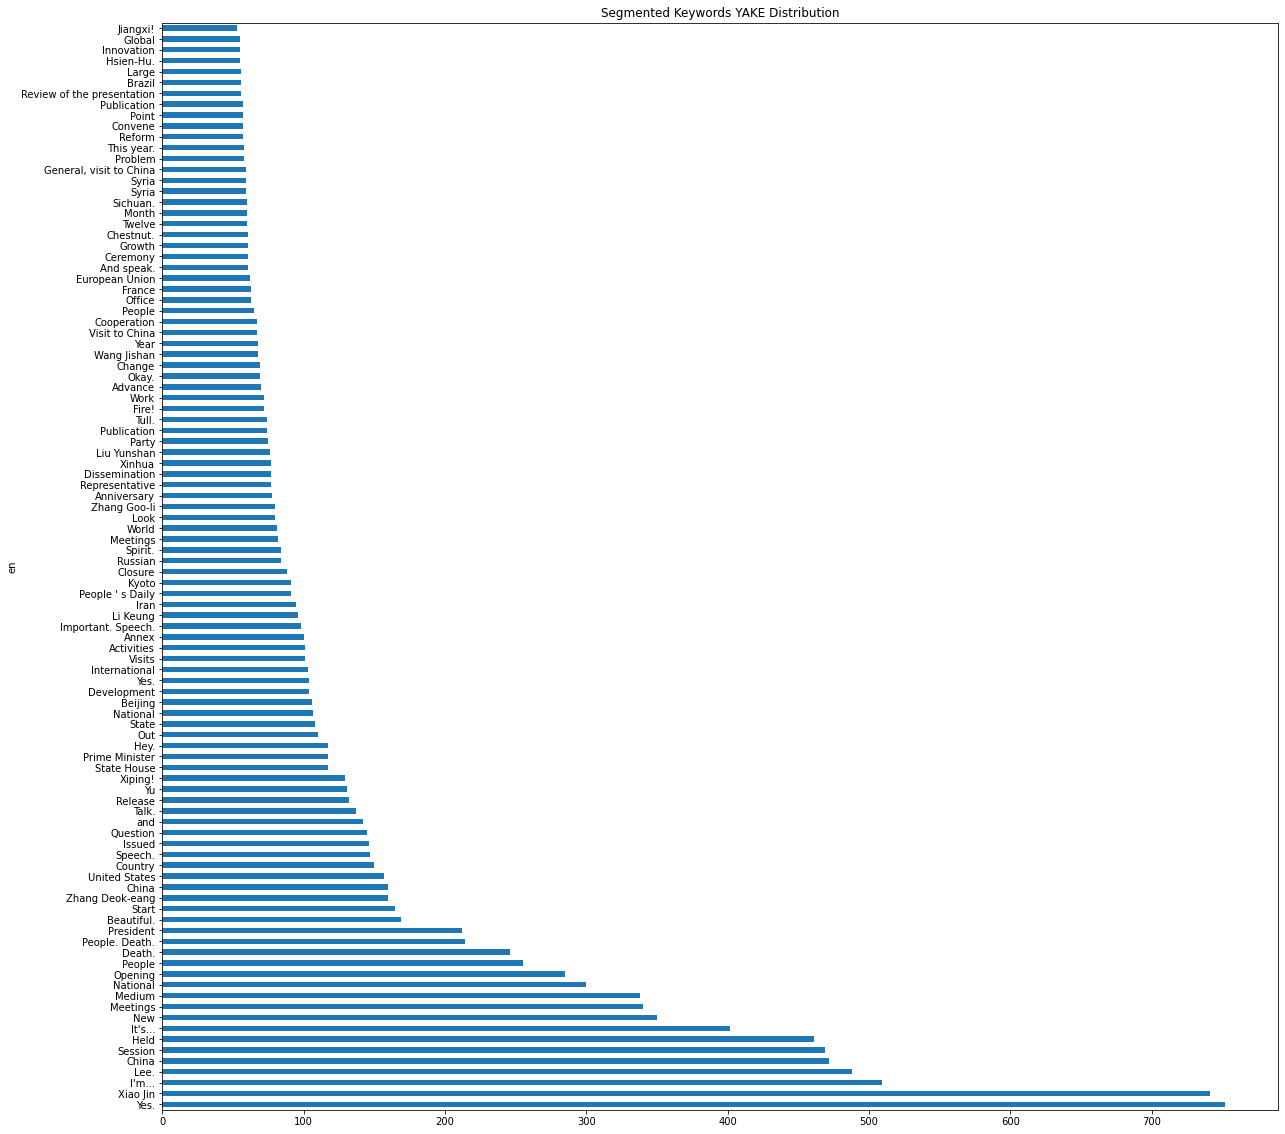

In [ ]:
top_100_seg_zh.index = top_100_seg_zh.en
top_100_seg_zh.keywords_classes.plot.barh(figsize=(20,20), title = 'Segmented Keywords YAKE Distribution')

# Apply Yake to Segmented and Lemmatized data

In [ ]:
# Automated Word Segmentation Included!
zh_lem_df = nlu.load('zh.lemma').predict(df.headline)
zh_lem_df

lemma download started this may take some time.
Approximate size to download 149.5 KB
[OK!]
wordseg_weibo download started this may take some time.
Approximate size to download 1.2 MB
[OK!]


,headline,lemma,document,text
origin_index,,,,
0,陆军领导机构火箭军战略支援部队成立大会在京举行 习近平向中国人民解放军陆军火箭军战略支援部队...,"[陆领, 军, 导机, 构火, 箭军, 战, 略, 支, 援, 部, 队, 成立, 大会, ...",陆军领导机构火箭军战略支援部队成立大会在京举行 习近平向中国人民解放军陆军火箭军战略支援部队...,陆军领导机构火箭军战略支援部队成立大会在京举行 习近平向中国人民解放军陆军火箭军战略支援部队...
1,中央军委印发《关于深化国防和军队改革的意见》,"[中央委, 军, 印发, 《, 关于, 深化, 国防, 和, 军队, 改革, 的, 意见, 》]",中央军委印发《关于深化国防和军队改革的意见》,中央军委印发《关于深化国防和军队改革的意见》
2,《习近平关于严明党的纪律和规矩论述摘编》出版发行,"[《, 习近, 平关于, 严明, 党, 的, 纪律, 和, 规述, 矩, 论, 摘编, 》,...",《习近平关于严明党的纪律和规矩论述摘编》出版发行,《习近平关于严明党的纪律和规矩论述摘编》出版发行
3,以实际行动向党中央看齐 向高标准努力,"[以, 实际, 行动, 向, 党中, 央看, 齐向, 高准, 标, 努力]",以实际行动向党中央看齐 向高标准努力,以实际行动向党中央看齐 向高标准努力
4,【年终特稿】关键之年 改革挺进深水区,"[【, 年终, 特, 稿, 】, 关键, 之年改革, 挺进, 深水区]",【年终特稿】关键之年 改革挺进深水区,【年终特稿】关键之年 改革挺进深水区
...,...,...,...,...
20733,部分反政府武装从伊德利卜撤重武器,"[部分, 反, 政府, 武装, 从伊德利卜, 撤重, 武, 器]",部分反政府武装从伊德利卜撤重武器,部分反政府武装从伊德利卜撤重武器
20734,IMF下调今明两年世界经济增长预期,"[IMF, 下, 调, 今明, 两年, 世界, 经, 济, 增长, 预期]",IMF下调今明两年世界经济增长预期,IMF下调今明两年世界经济增长预期
20735,乌克兰一军火库爆炸 上万人疏散,"[乌克兰, 一军, 火库, 爆炸, 上, 万人, 疏散]",乌克兰一军火库爆炸 上万人疏散,乌克兰一军火库爆炸 上万人疏散


## Join tokens into whitespace seperated string like we did previosuly for Word Segmentation

In [ ]:
zh_lem_df['lem_str'] = zh_lem_df.lemma.str.join(' ')
zh_lem_df

,headline,lemma,document,text,lem_str
origin_index,,,,,
0,陆军领导机构火箭军战略支援部队成立大会在京举行 习近平向中国人民解放军陆军火箭军战略支援部队...,"[陆领, 军, 导机, 构火, 箭军, 战, 略, 支, 援, 部, 队, 成立, 大会, ...",陆军领导机构火箭军战略支援部队成立大会在京举行 习近平向中国人民解放军陆军火箭军战略支援部队...,陆军领导机构火箭军战略支援部队成立大会在京举行 习近平向中国人民解放军陆军火箭军战略支援部队...,陆领 军 导机 构火 箭军 战 略 支 援 部 队 成立 大会 在 京 举 行 习近 平向 ...
1,中央军委印发《关于深化国防和军队改革的意见》,"[中央委, 军, 印发, 《, 关于, 深化, 国防, 和, 军队, 改革, 的, 意见, 》]",中央军委印发《关于深化国防和军队改革的意见》,中央军委印发《关于深化国防和军队改革的意见》,中央委 军 印发 《 关于 深化 国防 和 军队 改革 的 意见 》
2,《习近平关于严明党的纪律和规矩论述摘编》出版发行,"[《, 习近, 平关于, 严明, 党, 的, 纪律, 和, 规述, 矩, 论, 摘编, 》,...",《习近平关于严明党的纪律和规矩论述摘编》出版发行,《习近平关于严明党的纪律和规矩论述摘编》出版发行,《 习近 平关于 严明 党 的 纪律 和 规述 矩 论 摘编 》 出版 发行
3,以实际行动向党中央看齐 向高标准努力,"[以, 实际, 行动, 向, 党中, 央看, 齐向, 高准, 标, 努力]",以实际行动向党中央看齐 向高标准努力,以实际行动向党中央看齐 向高标准努力,以 实际 行动 向 党中 央看 齐向 高准 标 努力
4,【年终特稿】关键之年 改革挺进深水区,"[【, 年终, 特, 稿, 】, 关键, 之年改革, 挺进, 深水区]",【年终特稿】关键之年 改革挺进深水区,【年终特稿】关键之年 改革挺进深水区,【 年终 特 稿 】 关键 之年改革 挺进 深水区
...,...,...,...,...,...
20733,部分反政府武装从伊德利卜撤重武器,"[部分, 反, 政府, 武装, 从伊德利卜, 撤重, 武, 器]",部分反政府武装从伊德利卜撤重武器,部分反政府武装从伊德利卜撤重武器,部分 反 政府 武装 从伊德利卜 撤重 武 器
20734,IMF下调今明两年世界经济增长预期,"[IMF, 下, 调, 今明, 两年, 世界, 经, 济, 增长, 预期]",IMF下调今明两年世界经济增长预期,IMF下调今明两年世界经济增长预期,IMF 下 调 今明 两年 世界 经 济 增长 预期
20735,乌克兰一军火库爆炸 上万人疏散,"[乌克兰, 一军, 火库, 爆炸, 上, 万人, 疏散]",乌克兰一军火库爆炸 上万人疏散,乌克兰一军火库爆炸 上万人疏散,乌克兰 一军 火库 爆炸 上 万人 疏散


## Extract Keywords on Stemmed + Word Segmented Chinese text

In [ ]:
yake_lem_df = nlu.load('yake').predict(zh_lem_df.lem_str)
yake_lem_df

,lem_str,keywords_classes,document,keywords_confidences,text
origin_index,,,,,
0,陆领 军 导机 构火 箭军 战 略 支 援 部 队 成立 大会 在 京 举 行 习近 平向 ...,"[箭军 战, 战 略, 箭军 战, 战 略, 箭军 战 略, 箭军 战 略]",陆领 军 导机 构火 箭军 战 略 支 援 部 队 成立 大会 在 京 举 行 习近 平向 ...,"[0.15066084265708923, 0.18981841206550598, 0.1...",陆领 军 导机 构火 箭军 战 略 支 援 部 队 成立 大会 在 京 举 行 习近 平向 ...
1,中央委 军 印发 《 关于 深化 国防 和 军队 改革 的 意见 》,"[中央委, 印发, 军队]",中央委 军 印发 《 关于 深化 国防 和 军队 改革 的 意见 》,"[0.6040937304496765, 0.7494153380393982, 0.749...",中央委 军 印发 《 关于 深化 国防 和 军队 改革 的 意见 》
2,《 习近 平关于 严明 党 的 纪律 和 规述 矩 论 摘编 》 出版 发行,"[党, 发行, 出版 发行]",《 习近 平关于 严明 党 的 纪律 和 规述 矩 论 摘编 》 出版 发行,"[0.7494153380393982, 0.354549765586853, 0.3618...",《 习近 平关于 严明 党 的 纪律 和 规述 矩 论 摘编 》 出版 发行
3,以 实际 行动 向 党中 央看 齐向 高准 标 努力,"[以, 努力, 标 努力]",以 实际 行动 向 党中 央看 齐向 高准 标 努力,"[0.6040937304496765, 0.354549765586853, 0.3618...",以 实际 行动 向 党中 央看 齐向 高准 标 努力
4,【 年终 特 稿 】 关键 之年改革 挺进 深水区,"[深水区, 挺进 深水区, 之年改革 挺进 深水区]",【 年终 特 稿 】 关键 之年改革 挺进 深水区,"[0.354549765586853, 0.3618505299091339, 0.6524...",【 年终 特 稿 】 关键 之年改革 挺进 深水区
...,...,...,...,...,...
20733,部分 反 政府 武装 从伊德利卜 撤重 武 器,"[部分, 器, 武 器]",部分 反 政府 武装 从伊德利卜 撤重 武 器,"[0.6040937304496765, 0.354549765586853, 0.3618...",部分 反 政府 武装 从伊德利卜 撤重 武 器
20734,IMF 下 调 今明 两年 世界 经 济 增长 预期,"[imf, 预期, 增长 预期]",IMF 下 调 今明 两年 世界 经 济 增长 预期,"[0.45423248410224915, 0.354549765586853, 0.361...",IMF 下 调 今明 两年 世界 经 济 增长 预期
20735,乌克兰 一军 火库 爆炸 上 万人 疏散,"[乌克兰, 疏散, 万人 疏散]",乌克兰 一军 火库 爆炸 上 万人 疏散,"[0.6040937304496765, 0.354549765586853, 0.3618...",乌克兰 一军 火库 爆炸 上 万人 疏散


In [ ]:
top_100_stem = yake_lem_df.explode('keywords_classes').keywords_classes.value_counts()[:100]
top_100_stem = pd.DataFrame(top_100_stem)
# Create new DF from the counts
top_100_stem['zh'] = top_100_stem.index
top_100_stem.reset_index(inplace=True)
# Write Translations back to df with keyword counts

top_100_stem['en']  = nlu.load('zh.translate_to.en').predict(top_100_stem.zh).translation
top_100_stem

translate_zh_en download started this may take some time.
Approx size to download 396.8 MB
[OK!]


,index,keywords_classes,zh,en
0,习近,849,习近,Xiao Jin
1,会,791,会,Yes.
2,李,665,李,Lee.
3,议,582,议,Session
4,我,520,我,I'm...
...,...,...,...,...
95,指,57,指,Point
96,改革,57,改革,Reform
97,巴西,56,巴西,Brazil
98,全球,55,全球,Global


# Plot the Segmented and Lemmatized Distribution of extracted keywords 

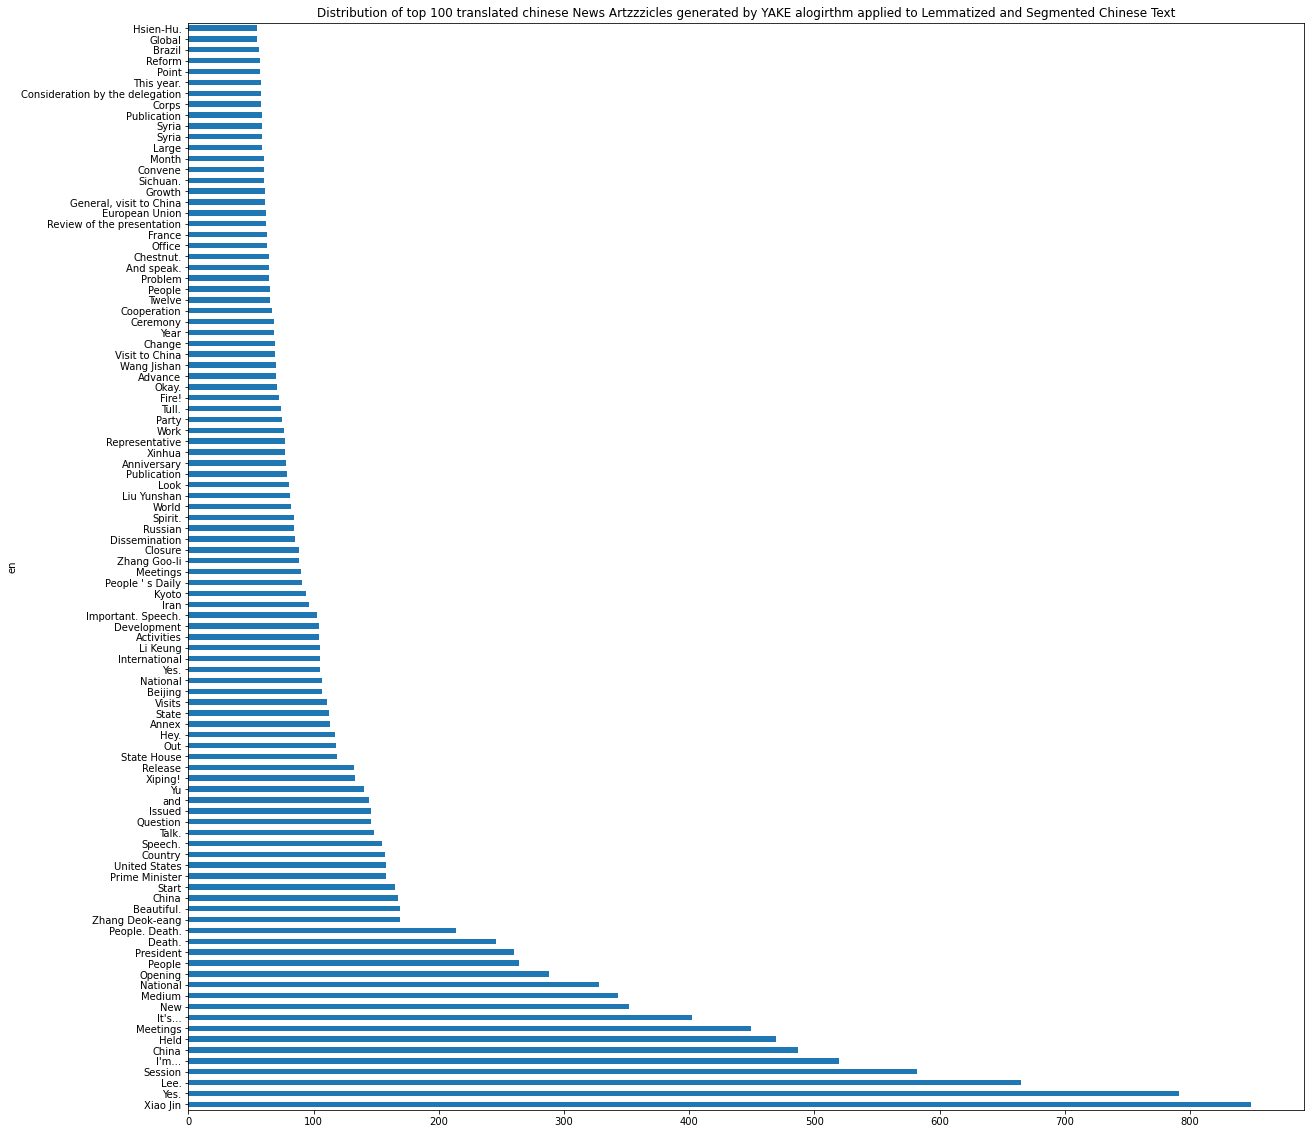

In [ ]:
top_100_stem.index = top_100_stem.en
top_100_stem.keywords_classes.plot.barh(figsize=(20,20), title='Distribution of top 100 translated chinese News Artzzzicles generated by YAKE alogirthm applied to Lemmatized and Segmented Chinese Text')

# Extract Chinese Named entities

In [ ]:
zh_ner_df = nlu.load('zh.ner').predict(df.iloc[:1000].headline, output_level='document')
zh_ner_df

ner_msra_bert_768d download started this may take some time.
Approximate size to download 19.2 MB
[OK!]
bert_base_chinese download started this may take some time.
Approximate size to download 367.6 MB
[OK!]
wordseg_weibo download started this may take some time.
Approximate size to download 1.2 MB
[OK!]


,headline,text,entities,word_embeddings,document,entities_confidence,ner_confidence
origin_index,,,,,,,
0,陆军领导机构火箭军战略支援部队成立大会在京举行 习近平向中国人民解放军陆军火箭军战略支援部队...,陆军领导机构火箭军战略支援部队成立大会在京举行 习近平向中国人民解放军陆军火箭军战略支援部队...,"[陆军, 构火箭军, 成立大会, 京, 习近平向中国, 民解放军陆军, 箭军, 援部队授予]","[[0.24575406312942505, 0.44130945205688477, -0...",陆军领导机构火箭军战略支援部队成立大会在京举行 习近平向中国人民解放军陆军火箭军战略支援部队...,"[G, G, C, C, R, G, G, G]","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,中央军委印发《关于深化国防和军队改革的意见》,中央军委印发《关于深化国防和军队改革的意见》,"[中央军, 关于深化国防, 军队, 意见]","[[-0.32814911007881165, 0.2702528238296509, -0...",中央军委印发《关于深化国防和军队改革的意见》,"[G, R, G, C]","[1.0, 1.0, 0.8112999796867371, 1.0, 0.99980002..."
2,《习近平关于严明党的纪律和规矩论述摘编》出版发行,《习近平关于严明党的纪律和规矩论述摘编》出版发行,"[习近平关于严明, 纪律, 出版发行]","[[-0.4957573711872101, 0.18991678953170776, 0....",《习近平关于严明党的纪律和规矩论述摘编》出版发行,"[R, C, G]","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6686999797821..."
3,以实际行动向党中央看齐 向高标准努力,以实际行动向党中央看齐 向高标准努力,"[行动, 党中央看齐 , 努力]","[[0.4508194327354431, 0.5100938081741333, -0.2...",以实际行动向党中央看齐 向高标准努力,"[G, G, R]","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
4,【年终特稿】关键之年 改革挺进深水区,【年终特稿】关键之年 改革挺进深水区,[关键之年 改革挺进深水区],"[[0.5741986036300659, 0.1778355985879898, 1.37...",【年终特稿】关键之年 改革挺进深水区,[C],"[1.0, 0.9986000061035156, 1.0, 1.0, 1.0, 0.999..."
...,...,...,...,...,...,...,...
995,【改革追踪看落实】湖北：督察较真碰硬 改革板上钉钉,【改革追踪看落实】湖北：督察较真碰硬 改革板上钉钉,"[改革, 落实, 湖, 督察]","[[0.37848663330078125, 0.014652982354164124, 0...",【改革追踪看落实】湖北：督察较真碰硬 改革板上钉钉,"[G, G, C, G]","[1.0, 1.0, 1.0, 1.0, 1.0, 0.9186999797821045, ..."
996,“天宫二号”完成总装 载人航天再启程,“天宫二号”完成总装 载人航天再启程,"[天宫二号, 航天, 启程]","[[-0.5486707091331482, 0.7842122316360474, 0.3...",“天宫二号”完成总装 载人航天再启程,"[C, C, R]","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
997,《治国理政新征程》系列特别报道第五集,《治国理政新征程》系列特别报道第五集,"[治国, 政新征程, 系列, 第五集]","[[-0.0011867359280586243, -0.10596790164709091...",《治国理政新征程》系列特别报道第五集,"[C, G, R, C]","[1.0, 0.9156000018119812, 1.0, 0.9998999834060..."


In [ ]:
# Translate Detected Chinese Entities to English
en_entities = nlu.load('zh.translate_to.en').predict(zh_ner_df.explode('entities').entities)
en_entities

translate_zh_en download started this may take some time.
Approx size to download 396.8 MB
[OK!]


,sentence,entities,translation,text
origin_index,,,,
0,陆军,陆军,Army,陆军
0,构火箭军,构火箭军,- The rocket army.,构火箭军
0,成立大会,成立大会,Assembly of the Nations,成立大会
0,京,京,Kyoto,京
0,习近平向中国,习近平向中国,Xi Jinping is heading for China,习近平向中国
...,...,...,...,...
997,第五集,第五集,Episode 5,第五集
998,三八,三八,Bitch!,三八
998,国际妇女节纪念大会,国际妇女节纪念大会,International Women ' s Day commemorative cong...,国际妇女节纪念大会


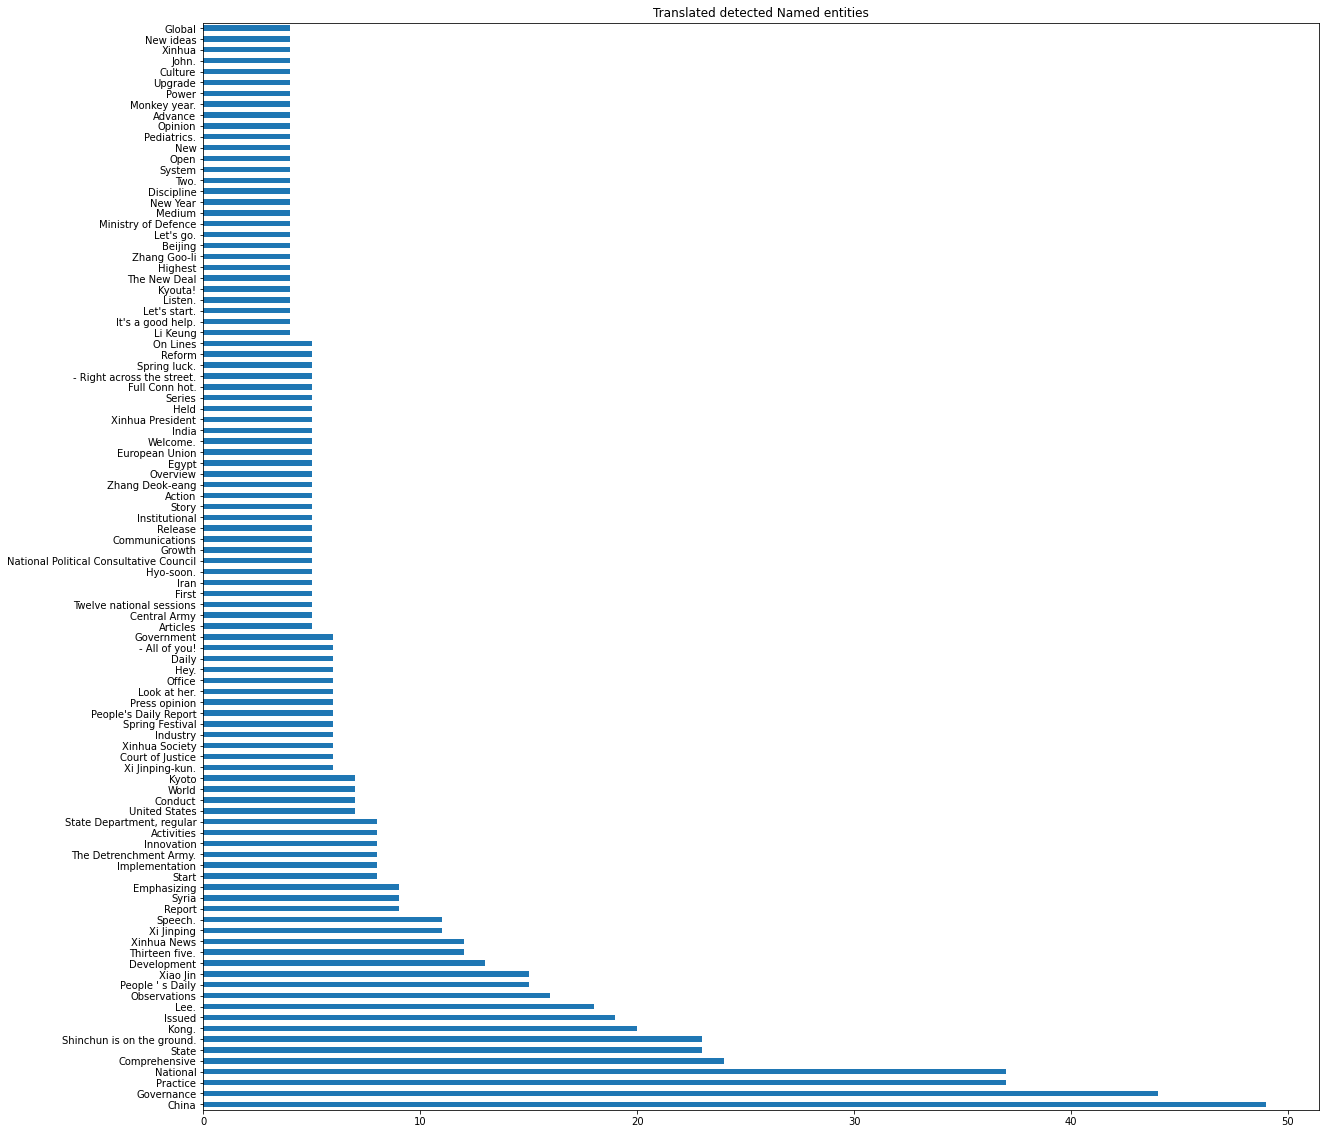

In [ ]:
en_entities.translation.value_counts()[0:100].plot.barh(figsize=(20,20), title = "Top 100 Translated detected Named entities")

# There are many more models!
## Checkout [the Modelshub](https://nlp.johnsnowlabs.com/models) and the [NLU Namespace](https://nlu.johnsnowlabs.com/docs/en/spellbook) for more models